In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.layers import CuDNNLSTM

from numpy.random import seed

In [2]:
# definição da seed do python
seed(1)
# e seed do tensorflow
tf.random.set_seed(2)

In [3]:
# definição do ficheiro de dados (treino/validação)
# symbol = 'ada'
crypto_ta_dataset_fp = "datasets/crypto_ta_btc_02.csv"

In [4]:
# Nomes das classses
# class_names = ['Very Low', 'Low', 'High', 'Very High']
class_names = ['Low', 'High', 'Neutral']

In [5]:
# ler o ficheiro de dados, indicando o ficheiro e indicamos os nomes das colunas (que não estão no ficheiro)
crypto_ta_dataset = pd.read_csv(crypto_ta_dataset_fp)
# remover as colunas que nao interessam
# crypto_ta_dataset.drop('', axis=1, inplace=True)
# imprime um as primeiras linhas dos dados
print(crypto_ta_dataset.head())

# colunas que são features e coluna que é a label (a ultima neste caso)
feature_names = crypto_ta_dataset.columns[:-1]
label_name = crypto_ta_dataset.columns[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

     price     sma_200       ema_8      ema_20      ema_25      ema_30  \
0  444.789  391.802118  451.280749  440.756688  437.772289  435.337879   
1  449.381  392.811327  450.858583  441.578051  438.665267  436.243887   
2  456.566  393.866327  452.126898  443.005475  440.042247  437.554991   
3  447.903  394.858816  451.188254  443.471906  440.646920  438.222604   
4  452.592  395.858298  451.500197  444.340486  441.565772  439.149662   

       ema_35      ema_40      ema_45      ema_50  ...  bbands_mid  \
0  433.294637  431.533509  429.976983  428.562492  ...   436.64335   
1  434.188324  432.404118  430.820636  429.378904  ...   438.18870   
2  435.431528  433.582747  431.940000  430.445064  ...   440.20975   
3  436.124388  434.281296  432.634043  431.129689  ...   441.54825   
4  437.039255  435.174501  433.501781  431.971348  ...   443.04865   

   bbands_low        cmo      macd  macdsignal    macdhist       ppo  \
0  406.509834  11.508362  9.974195    8.023714  -44.011506  2.

In [6]:
crypto_ta_dataset[label_name] = crypto_ta_dataset[label_name].map(
    {"LOW":0,"HIGH":1,"NEUTRAL":2})

# print(crypto_ta_dataset)
# criamos duas variáveis, uma para os dados e outra para as labels (vamos precisar depois)
features = crypto_ta_dataset.copy()
labels = features.pop(label_name)
# normalization dataset
features = tf.keras.utils.normalize(features, axis=-1, order=1)

# imprime um resumo dos valores
print(features)

              price       sma_200         ema_8        ema_20        ema_25  \
0      4.682402e-07  4.124596e-07  4.750742e-07  4.639952e-07  4.608535e-07   
1      4.546597e-07  3.974256e-07  4.561547e-07  4.467651e-07  4.438181e-07   
2      4.644662e-07  4.006816e-07  4.599503e-07  4.506710e-07  4.476565e-07   
3      4.535080e-07  3.998000e-07  4.568343e-07  4.490214e-07  4.461611e-07   
4      4.657025e-07  4.073254e-07  4.645791e-07  4.572120e-07  4.543569e-07   
...             ...           ...           ...           ...           ...   
22702  1.236526e-06  1.161927e-06  1.223423e-06  1.217185e-06  1.214861e-06   
22703  1.232663e-06  1.153586e-06  1.218263e-06  1.210310e-06  1.207728e-06   
22704  1.216700e-06  1.145361e-06  1.210815e-06  1.202712e-06  1.200064e-06   
22705  1.208925e-06  1.137247e-06  1.203371e-06  1.195188e-06  1.192484e-06   
22706  1.205586e-06  1.128794e-06  1.196536e-06  1.187713e-06  1.184875e-06   

             ema_30        ema_35        ema_40    

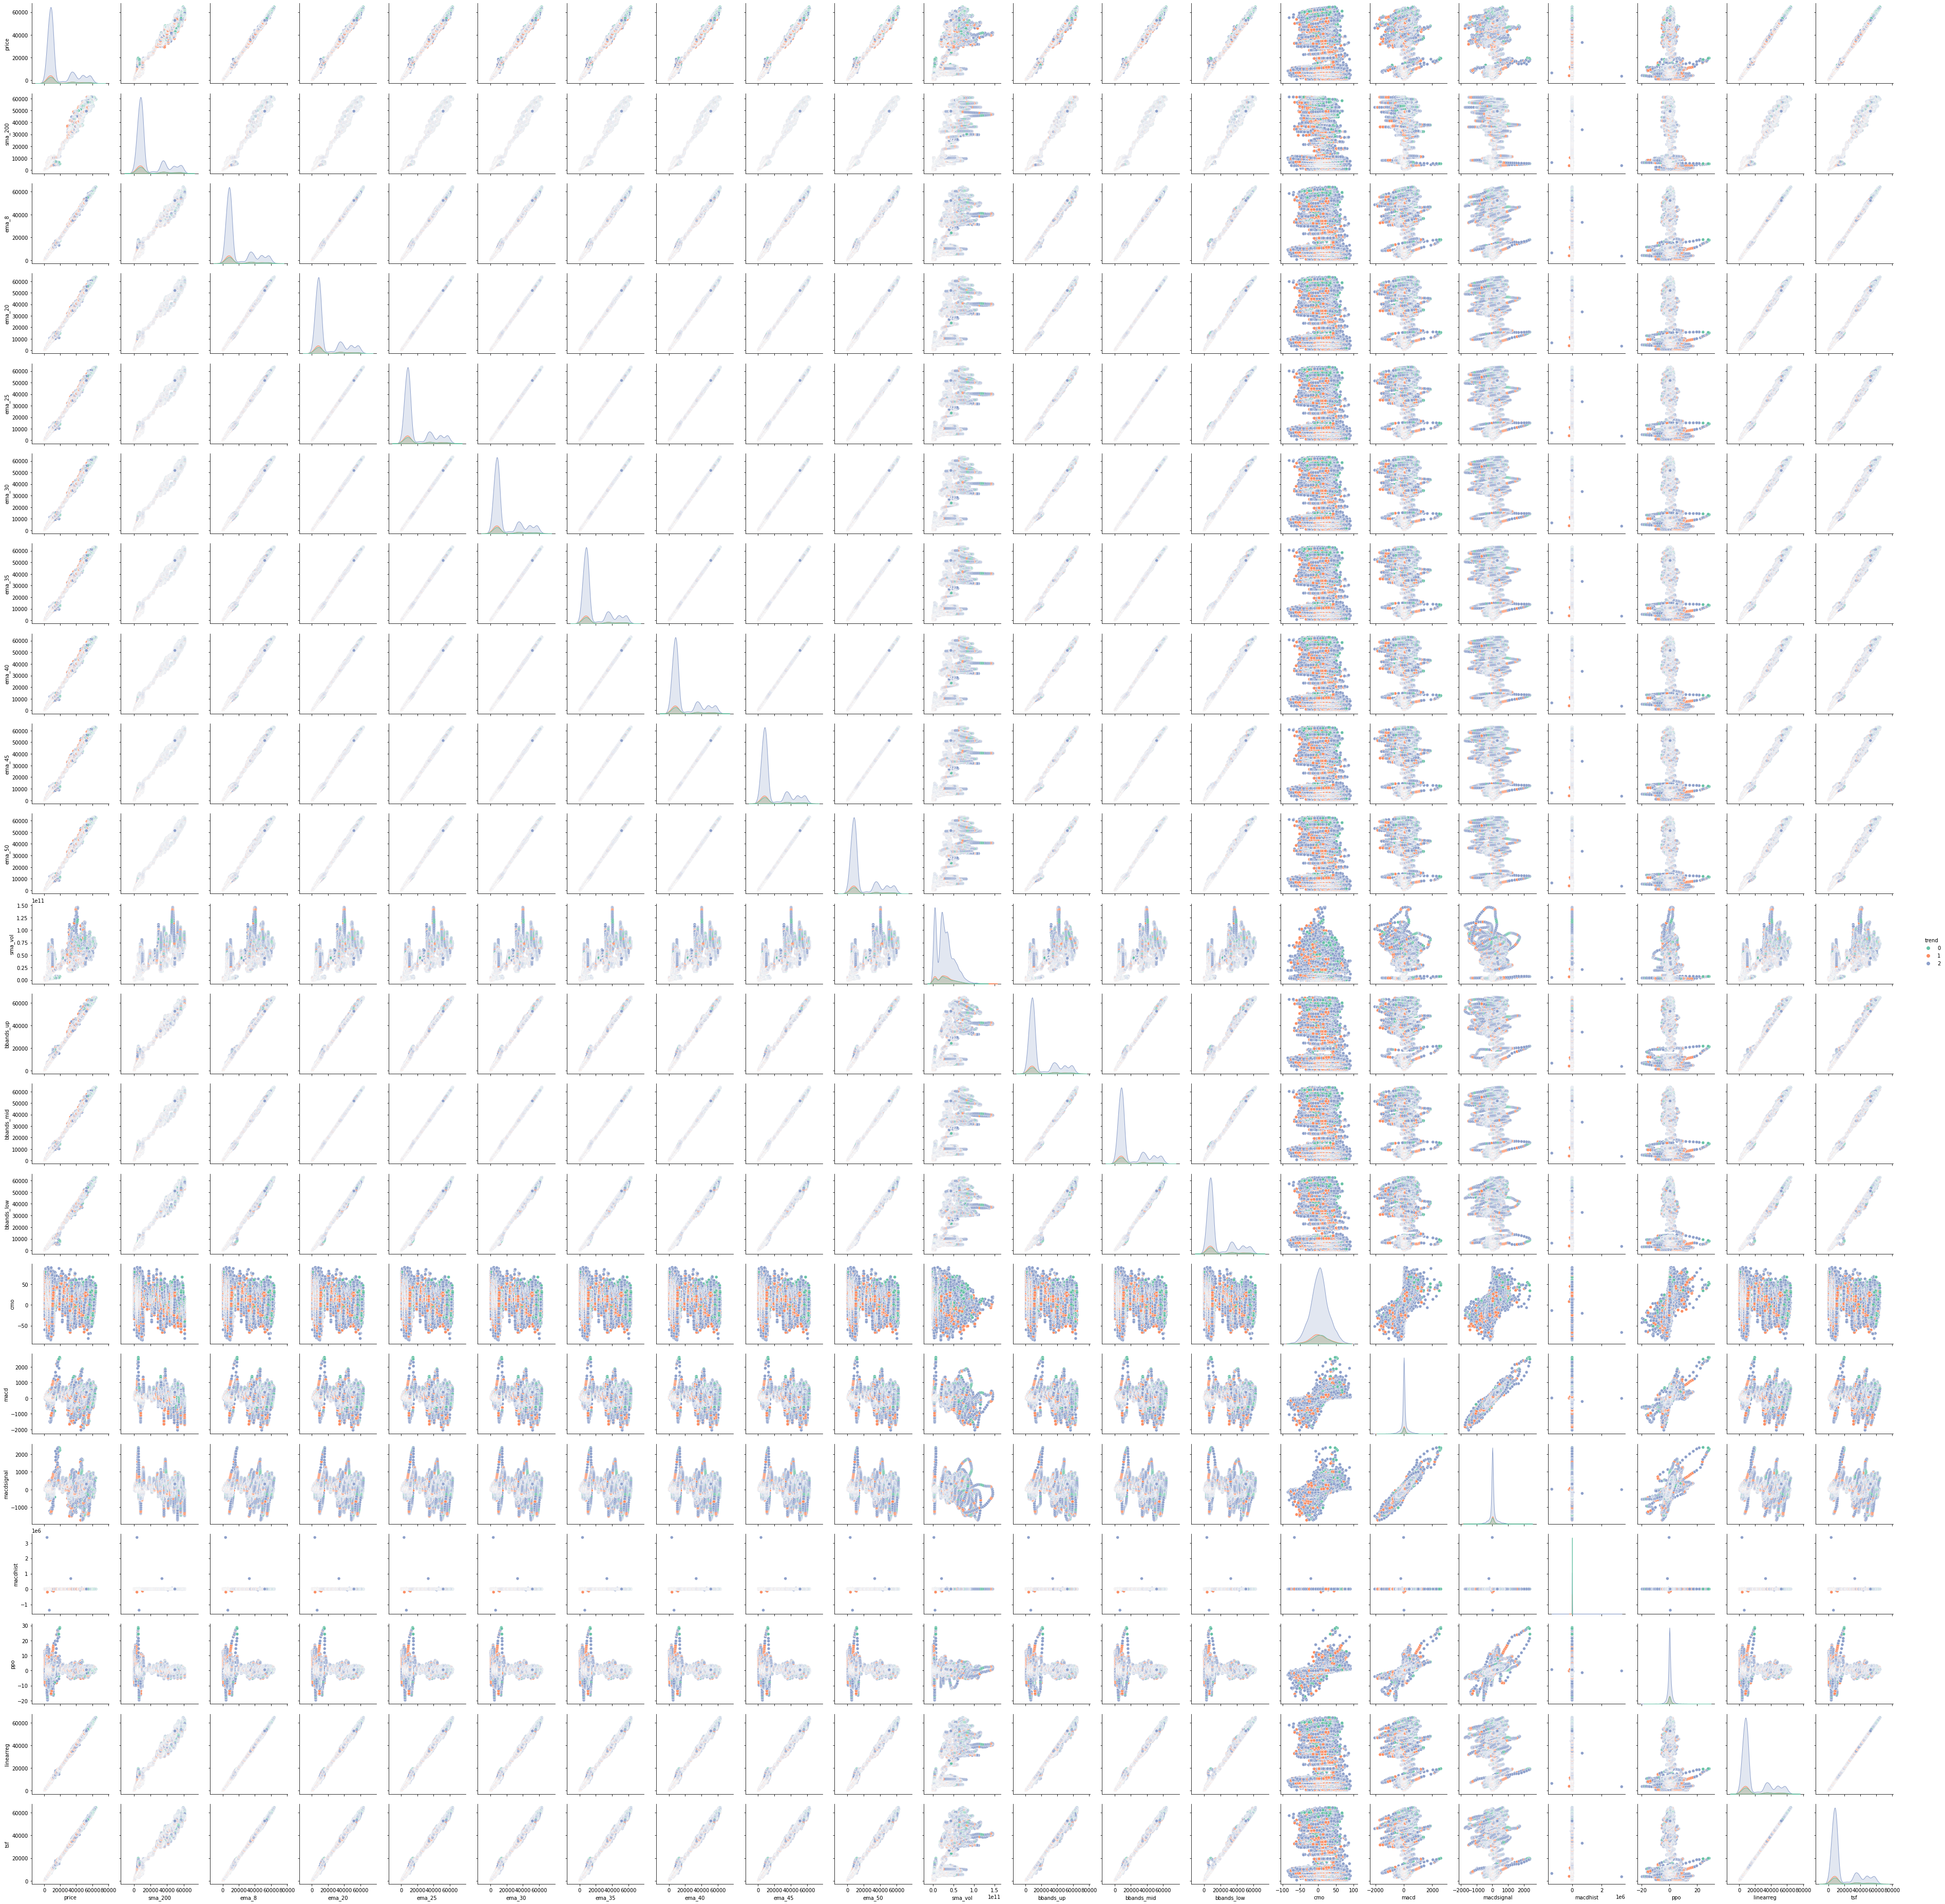

In [7]:
sns_plot = sns.pairplot(crypto_ta_dataset,hue=label_name,palette='Set2')
sns_plot.savefig("output.png")

In [8]:
# definir a estrutra a rede neuronal a utilizar
# Neste caso temos duas camadas escondidas com 10 nós
#     - Ativação do tipo relu (podem usar outras mas podem também escolher manter)
#     - Dense significa que cada camada liga a todas as outras (recomendado)
#     - Na primeira camada escondida indica-se, no parametro input_shape, que temos  entradas
# A camada de saída deve ter o mesmo número de saídas que o número de classes
#     - Por default a camada de saída devolve um logit para cada classe.
#     - Um logit é um numero entre -Inf e +Inf que representa a classificação antes de ser normalizada
#     - Podemos normalizar o resultado depois  para probalidades (usando a função softmax)
#     - Podemos também indicar que esta camada usa logo a softmax mas não é recomendado
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation=tf.nn.relu, input_shape=(21,)),  # input shape required
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])


In [9]:
# definir as configurações do algoritmo
# - Algoritmo usado para optimização (neste caso o SGD) com a learning rate 
#    - Podem decidir ajustar este parametro mas não é obrigatório
# - Função que será usada para a minimização na procura
#    - Neste caso usamos a SparseCategoricalCrossentropy
#    - SparseCategorical é usada quanda trabalhamos com inteiros como target
#    - from_logits=True indica que a saída da rede são logits
#        - Se não usarmos este parametro temos de usar a softmax na saída da rede
# - As metricas não são usadas para optimização, são usadas para dar output de resultados
#    - Podem-se usar várias métricas ao mesmo tempo, dará vários valores de output
#    - Neste caso estamos a usar a Accuracy (número )

# definir as configurações do algoritmo

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [10]:
# 1- Criar o Dataset
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

# Percentages de teste e validação
TEST_PERC = 0.1
VALID_PERC = 0.1

In [11]:
# 2- Separar por classe (vai permitir garantir que cada conjunto tem X de cada classe)
class0_dataset = dataset.filter(lambda x, y: y == 0)
class1_dataset = dataset.filter(lambda x, y: y == 1)
class2_dataset = dataset.filter(lambda x, y: y == 2)
class3_dataset = dataset.filter(lambda x, y: y == 3)
print()
print(class0_dataset.cardinality())
# quantidade de cada classe e total
DATASIZE = dataset.cardinality().numpy()
c0_size = len(list(class0_dataset))
c1_size = len(list(class1_dataset))
c2_size = len(list(class2_dataset))
c3_size = len(list(class3_dataset))
print(DATASIZE,c0_size,c1_size,c2_size,c3_size)


tf.Tensor(-2, shape=(), dtype=int64)
22707 2107 2428 18172 0


In [12]:
# 3- Baralhar
class0_dataset = class0_dataset.shuffle(DATASIZE)
class1_dataset = class1_dataset.shuffle(DATASIZE)
class2_dataset = class2_dataset.shuffle(DATASIZE)
class3_dataset = class3_dataset.shuffle(DATASIZE)

In [13]:
# 4- Partir cada um
# Primeiro retiramos o teste
class0_test = class0_dataset.take(int(c0_size*TEST_PERC))
# variável temporária para separar entre treino e validação
# skip significa que vai ficar com o resto dos dados
rest = class0_dataset.skip(int(c0_size*TEST_PERC))
class0_validation = rest.take(int(c0_size*VALID_PERC))
class0_train = rest.skip(int(c0_size*VALID_PERC))

class1_test = class1_dataset.take(int(c1_size*TEST_PERC))
rest = class1_dataset.skip(int(c1_size*TEST_PERC))
class1_validation = rest.take(int(c1_size*VALID_PERC))
class1_train = rest.skip(int(c1_size*VALID_PERC))

class2_test = class2_dataset.take(int(c2_size*TEST_PERC))
rest = class2_dataset.skip(int(c2_size*TEST_PERC))
class2_validation = rest.take(int(c2_size*VALID_PERC))
class2_train = rest.skip(int(c2_size*VALID_PERC))

class3_test = class3_dataset.take(int(c3_size*TEST_PERC))
rest = class3_dataset.skip(int(c3_size*TEST_PERC))
class3_validation = rest.take(int(c3_size*VALID_PERC))
class3_train = rest.skip(int(c3_size*VALID_PERC))

In [14]:
#5- Juntar tudo novamente
train_dataset = class0_train.concatenate(class1_train).concatenate(class2_train).concatenate(class3_train).shuffle(DATASIZE)
test_dataset = class0_test.concatenate(class1_test).concatenate(class2_test).concatenate(class3_test).shuffle(DATASIZE)
validation_dataset = class0_validation.concatenate(class1_validation).concatenate(class2_validation).concatenate(class3_validation).shuffle(DATASIZE)

#confirmar tamanhos
print('Train dataset size = ', len(list(train_dataset)))
print('Validation dataset size = ', len(list(validation_dataset)))
print('Test dataset size = ', len(list(test_dataset)))

Train dataset size =  18169
Validation dataset size =  2269
Test dataset size =  2269


In [15]:
#6- Usar o dataset diretamente para treinar, validar e testar

# Converter o conjunto de treino de novo para o formato inicial (DataFrame)
feat,lab = map(list,zip(*list(train_dataset.as_numpy_iterator())))
train_features= pd.DataFrame(data=feat,columns=feature_names)
train_labels = pd.DataFrame(data=lab,columns=[label_name])

feat,lab = map(list,zip(*list(validation_dataset.as_numpy_iterator())))
valid_features= pd.DataFrame(data=feat,columns=feature_names)
valid_labels = pd.DataFrame(data=lab,columns=[label_name])

feat,lab = map(list,zip(*list(test_dataset.as_numpy_iterator())))
test_features= pd.DataFrame(data=feat,columns=feature_names)
test_labels = pd.DataFrame(data=lab,columns=[label_name])

In [16]:
# Correr o treino, indica as features as labels e o número de épocas
history = model.fit(train_features, train_labels, epochs=100,validation_data=(valid_features,valid_labels))
print(history)

Epoch 1/100
568/568 [==============================] - 1s 2ms/step - loss: 0.7114 - sparse_categorical_accuracy: 0.7889 - val_loss: 0.6372 - val_sparse_categorical_accuracy: 0.8008
Epoch 2/100
568/568 [==============================] - 1s 1ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.8002 - val_loss: 0.6371 - val_sparse_categorical_accuracy: 0.8008
Epoch 3/100
568/568 [==============================] - 1s 1ms/step - loss: 0.6385 - sparse_categorical_accuracy: 0.8002 - val_loss: 0.6369 - val_sparse_categorical_accuracy: 0.8008
Epoch 4/100
568/568 [==============================] - 1s 1ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.8002 - val_loss: 0.6372 - val_sparse_categorical_accuracy: 0.8008
Epoch 5/100
568/568 [==============================] - 1s 1ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.8002 - val_loss: 0.6373 - val_sparse_categorical_accuracy: 0.8008
Epoch 6/100
568/568 [==============================] - 1s 1ms/step - loss: 0.6388 - sparse_cate

In [17]:
# Correr no conjunto teste (com o que foi treinado) e obter o resultado
test = model.evaluate(test_features,test_labels)
print("Teste:\n",test)
loss,acc = test

71/71 [==============================] - 0s 1ms/step - loss: 0.6369 - sparse_categorical_accuracy: 0.8008
Teste:
 [0.6369454860687256, 0.8007932901382446]


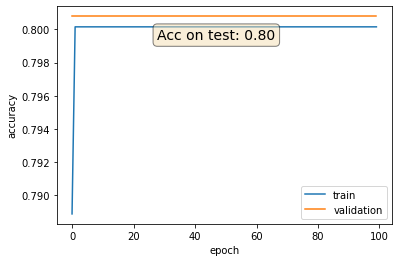

In [18]:
# ver um plot dos resultados de treino e teste 
# coloquei também o valor do teste, mas esse é só um ponto no final
# place a text box in upper left in axes coords
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.3, 0.90, "Acc on test: %.2f" % acc,  fontsize=14, transform=plt.axes().transAxes, 
        verticalalignment='top', bbox=props)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])

plt.show()